# SABR Smile Trading – Synthetic Relative Value Strategy

This notebook:

- Builds a synthetic option smile from a **true SABR model**
- Adds noise to create a "market" implied volatility smile
- Calibrates SABR back to the market smile (smoothing the noise)
- Uses the calibrated SABR smile as a **model of fair vols** vs noisy market quotes
- Takes simple trades:
  - Go **long** calls where market vol is too low vs SABR model
  - Go **short** calls where market vol is too high
- Simulates terminal prices and visualises the **PnL distribution** of th strategy.
e strategy.


In [20]:
import warnings
warnings.filterwarnings("ignore")  
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from math import log, sqrt, exp
from typing import Optional

In [22]:
def norm_cdf(x):
    """Standard normal CDF."""
    from math import erf
    x = np.asarray(x, dtype=float)
    return 0.5 * (1.0 + erf(x / np.sqrt(2.0)))


def bs_call_price(S0, K, T, r, sigma):
    """
    Black–Scholes European call price.

    Parameters
    ----------
    S0 : float
        Spot price at time 0.
    K : float
        Strike.
    T : float
        Time to maturity in years.
    r : float
        Risk-free rate (continuous compounding).
    sigma : float
        Volatility.

    Returns
    -------
    float
    """
    if T <= 0.0 or sigma <= 0.0:
        return max(S0 - K, 0.0)

    d1 = (log(S0 / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)

    return float(S0 * norm_cdf(d1) - K * exp(-r * T) * norm_cdf(d2))


In [24]:
@dataclass
class SabrParams:
    """
    Parameters of the lognormal SABR model.

    alpha : initial volatility level (>0)
    beta  : elasticity in [0, 1]
    rho   : correlation in [-1, 1]
    nu    : volatility of volatility (>0)
    """
    alpha: float
    beta: float
    rho: float
    nu: float


def sabr_implied_vol_hagan(F0, K, T, params: SabrParams, eps=1e-7):
    """
    Hagan et al. lognormal SABR implied volatility approximation.

    Parameters
    ----------
    F0 : float
        Forward price at time 0 (here we just treat it like S0).
    K : float or array-like
        Strike(s) > 0.
    T : float
        Maturity in years.
    params : SabrParams
        SABR parameters (alpha, beta, rho, nu).
    eps : float
        Threshold for deciding F0 ~ K (ATM limit).

    Returns
    -------
    float or np.ndarray
        Black–Scholes-equivalent implied vol(s).
    """
    alpha = float(params.alpha)
    beta = float(params.beta)
    rho = float(params.rho)
    nu = float(params.nu)

    if F0 <= 0.0:
        raise ValueError("F0 must be positive for lognormal SABR.")
    if T < 0.0:
        raise ValueError("T must be non-negative.")
    if alpha <= 0.0:
        raise ValueError("alpha must be positive.")
    if nu <= 0.0:
        raise ValueError("nu must be positive.")
    if not (0.0 <= beta <= 1.0):
        raise ValueError("beta must be in [0, 1].")
    if not (-1.0 <= rho <= 1.0):
        raise ValueError("rho must be in [-1, 1].")

    K_arr = np.asarray(K, dtype=float)
    if np.any(K_arr <= 0.0):
        raise ValueError("All strikes must be positive for lognormal SABR.")

    one_minus_beta = 1.0 - beta
    log_FK = np.log(F0 / K_arr)

    is_atm = np.abs(log_FK) < eps
    is_not_atm = ~is_atm

    sigma = np.zeros_like(K_arr, dtype=float)

    # --- ATM case ---
    if np.any(is_atm):
        F_beta = F0 ** one_minus_beta
        sigma_atm = alpha / F_beta

        term1 = ((one_minus_beta ** 2) / 24.0) * (alpha ** 2) / (F_beta ** 2)
        term2 = 0.25 * rho * beta * nu * alpha / F_beta
        term3 = ((2.0 - 3.0 * rho * rho) / 24.0) * (nu ** 2)

        correction = 1.0 + T * (term1 + term2 + term3)
        sigma[is_atm] = sigma_atm * correction

    # --- Non-ATM case ---
    if np.any(is_not_atm):
        K_ = K_arr[is_not_atm]
        log_FK_ = log_FK[is_not_atm]

        FK_beta = (F0 * K_) ** (0.5 * one_minus_beta)
        z = (nu / alpha) * FK_beta * log_FK_

        sqrt_term = np.sqrt(1.0 - 2.0 * rho * z + z * z)
        numerator = sqrt_term + z - rho
        denominator = 1.0 - rho
        x_z = np.log(numerator / denominator)

        # A(F0, K)
        A = alpha / (
            FK_beta
            * (
                1.0
                + (one_minus_beta**2 / 24.0) * (log_FK_**2)
                + (one_minus_beta**4 / 1920.0) * (log_FK_**4)
            )
        )

        zx = z / x_z

        term1 = ((one_minus_beta ** 2) / 24.0) * (alpha ** 2) / (FK_beta ** 2)
        term2 = 0.25 * rho * beta * nu * alpha / FK_beta
        term3 = ((2.0 - 3.0 * rho * rho) / 24.0) * (nu ** 2)
        B = 1.0 + T * (term1 + term2 + term3)

        sigma_non_atm = A * zx * B
        sigma[is_not_atm] = sigma_non_atm

    # --- Return scalar or array cleanly (FIXED) ---
    if sigma.ndim == 0:      # 0-D array for scalar K
        return float(sigma)
    else:
        return sigma


In [26]:
def sabr_calibration_error(F0, T, strikes, market_vols, params: SabrParams, weights=None):
    """Sum of squared errors between SABR vols and given market vols."""
    model_vols = sabr_implied_vol_hagan(F0, strikes, T, params)
    resid = model_vols - market_vols
    if weights is not None:
        resid = resid * weights
    return float(np.sum(resid**2))


def calibrate_sabr_grid(
    F0,
    T,
    strikes,
    market_vols,
    beta=0.5,
    weights=None,
    alpha_center=None,
):
    """
    Very simple SABR calibration via grid search over (alpha, rho, nu)
    for a fixed beta.

    Parameters
    ----------
    F0, T : float
    strikes, market_vols : array-like
        Smile data.
    beta : float
        Fixed beta.
    weights : array-like or None
    alpha_center : float or None
        If None, uses ATM vol as a proxy.

    Returns
    -------
    SabrParams
        Calibrated parameters.
    """
    strikes = np.asarray(strikes, dtype=float)
    market_vols = np.asarray(market_vols, dtype=float)

    if alpha_center is None:
        idx_atm = int(np.argmin(np.abs(strikes - F0)))
        sigma_atm = float(market_vols[idx_atm])
        alpha_center = sigma_atm * (F0 ** (1.0 - beta))

    # Rough grid setup
    alpha_grid = np.linspace(0.5 * alpha_center, 1.5 * alpha_center, 7)
    rho_grid = np.linspace(-0.9, 0.9, 7)
    nu_grid = np.linspace(0.1, 2.0, 7)

    best_err = float("inf")
    best_params = None
    evals = 0

    for alpha in alpha_grid:
        for rho in rho_grid:
            for nu in nu_grid:
                params = SabrParams(alpha=alpha, beta=beta, rho=rho, nu=nu)
                err = sabr_calibration_error(F0, T, strikes, market_vols, params, weights)
                evals += 1

                if err < best_err:
                    best_err = err
                    best_params = params

    print(f"[SABR calibration] Finished grid search with {evals} evaluations.")
    print(f"Best SSE: {best_err:.6f}")

    return best_params


In [28]:
@dataclass
class SabrTradingResult:
    F0: float
    T: float
    r: float
    params_true: SabrParams
    params_calibrated: SabrParams
    strikes: np.ndarray
    true_vols: np.ndarray
    market_vols: np.ndarray
    model_vols: np.ndarray
    mispricing_vol: np.ndarray
    trade_sides: np.ndarray      # +1 long call, -1 short call, 0 no trade
    ST_paths: np.ndarray         # terminal prices (n_paths,)
    pnl_paths: np.ndarray        # (n_paths, n_strikes)
    total_pnl_per_path: np.ndarray  # (n_paths,)


def build_synthetic_sabr_smile(
    F0,
    T,
    params_true: SabrParams,
    n_strikes=15,
    strike_span=0.4,
    noise_std=0.02,
    seed=42,
):
    """
    Build a synthetic SABR smile and a noisy "market" smile.

    - Strikes in [F0*(1-span), F0*(1+span)]
    - True vols from SABR
    - Market vols = true vols * (1 + noise)
    """
    rng = np.random.default_rng(seed)

    k_min = F0 * (1.0 - strike_span)
    k_max = F0 * (1.0 + strike_span)
    strikes = np.linspace(k_min, k_max, n_strikes)

    true_vols = sabr_implied_vol_hagan(F0, strikes, T, params_true)

    noise = rng.normal(0.0, noise_std, size=strikes.shape)
    market_vols = true_vols * (1.0 + noise)
    market_vols = np.maximum(market_vols, 1e-4)

    return strikes, true_vols, market_vols


def simulate_terminal_prices(F0, sigma_real, T, n_paths=10000, seed=123):
    """
    Simple lognormal terminal price model:

        S_T = F0 * exp( (-0.5 sigma^2) T + sigma sqrt(T) Z )
    """
    rng = np.random.default_rng(seed)
    Z = rng.standard_normal(size=n_paths)
    ST = F0 * np.exp((-0.5 * sigma_real**2) * T + sigma_real * np.sqrt(T) * Z)
    return ST


def run_sabr_smile_trading_experiment(
    F0=100.0,
    T=1.0,
    r=0.0,
    params_true: Optional[SabrParams] = None,
    beta=0.5,
    n_strikes=15,
    strike_span=0.4,
    noise_std=0.02,
    mispricing_threshold=0.05,
    n_paths=20000,
    seed=42,
) -> SabrTradingResult:
    """
    End-to-end SABR smile trading toy experiment:

    1. Choose "true" SABR parameters and create a synthetic smile.
    2. Add noise to get "market" vols.
    3. Calibrate SABR to the noisy smile (beta fixed).
    4. Use the calibrated SABR vols as fair vols.
    5. Define mispricing and a simple cross-sectional strategy:
       - If model_vol > market_vol*(1+threshold) -> long call
       - If model_vol < market_vol*(1-threshold) -> short call
    6. Simulate terminal prices with lognormal using true ATM SABR vol.
    7. Compute PnL distribution.
    """
    if params_true is None:
        params_true = SabrParams(alpha=0.25, beta=beta, rho=-0.4, nu=0.8)

    # 1–2: true vs market smile
    strikes, true_vols, market_vols = build_synthetic_sabr_smile(
        F0, T, params_true,
        n_strikes=n_strikes,
        strike_span=strike_span,
        noise_std=noise_std,
        seed=seed,
    )

    # 3: calibrate SABR to market smile
    params_calibrated = calibrate_sabr_grid(F0, T, strikes, market_vols, beta=beta)

    # 4: model vols from calibrated params
    model_vols = sabr_implied_vol_hagan(F0, strikes, T, params_calibrated)

    # 5: mispricing & trading rule
    rel_diff = (model_vols - market_vols) / market_vols

    trade_sides = np.zeros_like(strikes, dtype=int)
    trade_sides[rel_diff > mispricing_threshold] = 1   # long call
    trade_sides[rel_diff < -mispricing_threshold] = -1  # short call

    # 6: simulate terminal prices
    sigma_atm_true = float(sabr_implied_vol_hagan(F0, F0, T, params_true))
    ST_paths = simulate_terminal_prices(F0, sigma_atm_true, T, n_paths=n_paths, seed=seed)

    # 7: PnL
    prices_market = np.array([
        bs_call_price(F0, K, T, r, sigma_mkt)
        for K, sigma_mkt in zip(strikes, market_vols)
    ])

    payoffs = np.maximum(ST_paths[:, None] - strikes[None, :], 0.0)
    pnl_paths = trade_sides[None, :] * (payoffs - prices_market[None, :])
    total_pnl_per_path = pnl_paths.sum(axis=1)

    return SabrTradingResult(
        F0=F0,
        T=T,
        r=r,
        params_true=params_true,
        params_calibrated=params_calibrated,
        strikes=strikes,
        true_vols=true_vols,
        market_vols=market_vols,
        model_vols=model_vols,
        mispricing_vol=model_vols - market_vols,
        trade_sides=trade_sides,
        ST_paths=ST_paths,
        pnl_paths=pnl_paths,
        total_pnl_per_path=total_pnl_per_path,
    )


In [30]:
def plot_sabr_smile_and_trades(result: SabrTradingResult):
    strikes = result.strikes
    true_vols = result.true_vols
    market_vols = result.market_vols
    model_vols = result.model_vols
    trade_sides = result.trade_sides

    plt.figure(figsize=(10, 5))
    plt.plot(strikes, true_vols, label="True SABR vols", linestyle="--")
    plt.plot(strikes, model_vols, label="Calibrated SABR vols", linestyle="-")
    plt.scatter(strikes, market_vols, label="Market vols (noisy)", zorder=3)

    # Mark trades (avoid duplicate legend entries)
    plotted_long = False
    plotted_short = False
    for K, side, sigma_m in zip(strikes, trade_sides, market_vols):
        if side == 1:
            if not plotted_long:
                plt.scatter(K, sigma_m, marker="^", s=80, label="Long call")
                plotted_long = True
            else:
                plt.scatter(K, sigma_m, marker="^", s=80)
        elif side == -1:
            if not plotted_short:
                plt.scatter(K, sigma_m, marker="v", s=80, label="Short call")
                plotted_short = True
            else:
                plt.scatter(K, sigma_m, marker="v", s=80)

    plt.title("SABR Smile – True vs Calibrated vs Market (Noisy) with Trades")
    plt.xlabel("Strike K")
    plt.ylabel("Implied volatility")
    plt.grid(True)
    plt.legend()
    plt.show()

    print("=== SABR parameters ===")
    print(f"True params      : alpha={result.params_true.alpha:.3f}, "
          f"beta={result.params_true.beta:.3f}, "
          f"rho={result.params_true.rho:.3f}, "
          f"nu={result.params_true.nu:.3f}")
    print(f"Calibrated params: alpha={result.params_calibrated.alpha:.3f}, "
          f"beta={result.params_calibrated.beta:.3f}, "
          f"rho={result.params_calibrated.rho:.3f}, "
          f"nu={result.params_calibrated.nu:.3f}")
    print(f"Number of trades : {np.sum(result.trade_sides != 0)} "
          f"(long={np.sum(result.trade_sides > 0)}, "
          f"short={np.sum(result.trade_sides < 0)})")


def plot_sabr_pnl_distribution(result: SabrTradingResult):
    pnl = result.total_pnl_per_path

    plt.figure(figsize=(10, 5))
    plt.hist(pnl, bins=50, density=True)
    plt.axvline(0.0, color="black", linestyle="--", linewidth=1)
    plt.title("SABR Smile Trading – PnL Distribution")
    plt.xlabel("Total PnL per path")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

    mean_pnl = pnl.mean()
    std_pnl = pnl.std()
    p5 = np.percentile(pnl, 5)
    p50 = np.percentile(pnl, 50)
    p95 = np.percentile(pnl, 95)

    print("=== PnL summary ===")
    print(f"Mean PnL    : {mean_pnl:.4f}")
    print(f"Std PnL     : {std_pnl:.4f}")
    print(f"5% quantile : {p5:.4f}")
    print(f"Median      : {p50:.4f}")
    print(f"95% quantile: {p95:.4f}")


[SABR calibration] Finished grid search with 343 evaluations.
Best SSE: 0.000180


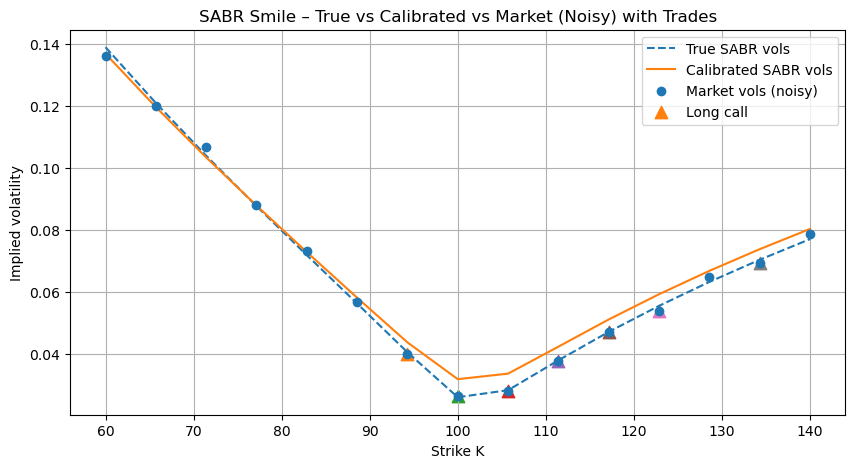

=== SABR parameters ===
True params      : alpha=0.250, beta=0.500, rho=-0.400, nu=0.800
Calibrated params: alpha=0.306, beta=0.500, rho=-0.300, nu=0.733
Number of trades : 7 (long=7, short=0)


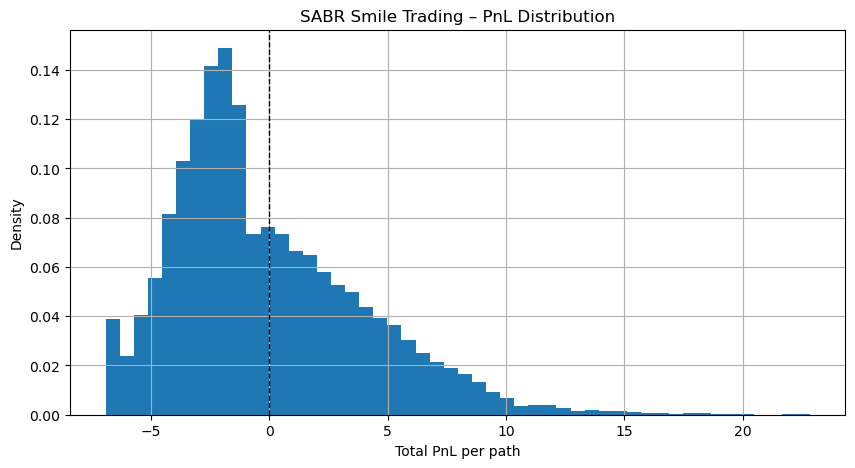

=== PnL summary ===
Mean PnL    : -0.1163
Std PnL     : 4.0393
5% quantile : -5.3724
Median      : -1.2267
95% quantile: 7.5457


In [32]:
res = run_sabr_smile_trading_experiment(
    F0=100.0,
    T=1.0,
    r=0.0,
    beta=0.5,
    n_strikes=15,
    strike_span=0.4,
    noise_std=0.02,
    mispricing_threshold=0.05,
    n_paths=20000,
    seed=123,
)

plot_sabr_smile_and_trades(res)
plot_sabr_pnl_distribution(res)
